## Import Package

In [1]:
import os
from collections import Counter
from datetime import date
from typing import Tuple
from itertools import product

import numpy as np
import pandas as pd
import xgboost as xg
import matplotlib.pyplot as plt
# from category_encoders.james_stein import JamesSteinEncoder
# from category_encoders.m_estimate import MEstimateEncoder
# from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import QuantileTransformer

## Prepare Function

In [11]:
encoder = TargetEncoder(
    random_state=0,
    target_type="continuous",
)

def get_year_month_day(date: str) -> Tuple[int]:
    return int(date[0:3+1]), int(date[5:6+1]), int(date[8:9+1])


def get_time(date: str) -> int:
    hr = date[11:12+1]
    min = date[14:15+1]
    sec = date[17:18+1]
    return int(hr) * 3600 + int(min) * 60 + int(sec)


def add_new_features(
    df: pd.DataFrame,
    encoder,
    is_train=True,
) -> pd.DataFrame:

    # like conunt
    df["like_count_2h-1h/1"] = df["like_count_2h"] - df["like_count_1h"]
    df["like_count_3h-2h/1"] = df["like_count_3h"] - df["like_count_2h"]
    df["like_count_4h-3h/1"] = df["like_count_4h"] - df["like_count_3h"]
    df["like_count_5h-4h/1"] = df["like_count_5h"] - df["like_count_4h"]
    df["like_count_6h-5h/1"] = df["like_count_6h"] - df["like_count_5h"]

    df["like_count_6h-1h/5"] = (df["like_count_6h"] - df["like_count_1h"]) / 5
    df["like_count_6h-2h/4"] = (df["like_count_6h"] - df["like_count_2h"]) / 4
    df["like_count_6h-3h/3"] = (df["like_count_6h"] - df["like_count_3h"]) / 3
    df["like_count_6h-4h/2"] = (df["like_count_6h"] - df["like_count_4h"]) / 2

    df["like_count_mean"] = (
        df["like_count_1h"] + df["like_count_2h"] + df["like_count_3h"] + df["like_count_4h"] + df["like_count_5h"] + df["like_count_6h"]
    ) / 6

    df["like_count_std"] = ((
        df["like_count_1h"] ** 2 + df["like_count_2h"] **2 + df["like_count_3h"] ** 2 + \
        df["like_count_4h"] ** 2 + df["like_count_5h"] **2 + df["like_count_6h"] ** 2
    ) / 6 - df["like_count_mean"] ** 2) ** 0.5

    df["like_count_mean/std"] = df["like_count_mean"] / df["like_count_std"]
    df.loc[df["like_count_std"] == 0, "like_count_mean/std"] = 0

    df["like_count_6h-1h/std"] = df["like_count_6h-1h/5"] * 5 / df["like_count_std"]
    df.loc[df["like_count_std"] == 0, "like_count_6h-1h/std"] = 0


    # comment count
    df["comment_count_2h-1h/1"] = df["comment_count_2h"] - df["comment_count_1h"]
    df["comment_count_3h-2h/1"] = df["comment_count_3h"] - df["comment_count_2h"]
    df["comment_count_4h-3h/1"] = df["comment_count_4h"] - df["comment_count_3h"]
    df["comment_count_5h-4h/1"] = df["comment_count_5h"] - df["comment_count_4h"]
    df["comment_count_6h-5h/1"] = df["comment_count_6h"] - df["comment_count_5h"]

    df["comment_count_6h-1h/5"] = (df["comment_count_6h"] - df["comment_count_1h"]) / 5
    df["comment_count_6h-2h/4"] = (df["comment_count_6h"] - df["comment_count_2h"]) / 4
    df["comment_count_6h-3h/3"] = (df["comment_count_6h"] - df["comment_count_3h"]) / 3
    df["comment_count_6h-4h/2"] = (df["comment_count_6h"] - df["comment_count_4h"]) / 2
    df["comment_count_6h-5h/1"] = (df["comment_count_6h"] - df["comment_count_5h"]) / 1


    # creat at
    df["weekday"] = df["created_at"].apply(lambda x: date(*get_year_month_day(x)).weekday() + 1)
    df["is_weekend"] = df["weekday"].apply(lambda x: True if x in [6, 7] else False)
    df["day"] = df["created_at"].apply(lambda x: int(x[8:9+1]))
    df["time"] = df["created_at"].apply(lambda x: get_time(x) + 1)


    # title
    df["title_len"] = df["title"].apply(lambda x: len(x))


    # category features
    df["weekday"] = df["weekday"].astype("str")
    df["is_weekend"] = df["is_weekend"].astype("str")
    df["author_id"] = df["author_id"].astype("str")
    df["forum_id"] = df["forum_id"].astype("str")

    if is_train:
        df[["weekday_te", "is_weekend_te", "author_id_te", "forum_id_te"]] = encoder.fit_transform(
            df[["weekday", "is_weekend", "author_id", "forum_id"]],
            df["like_count_24h"],
        )
    else:
        df[["weekday_te", "is_weekend_te", "author_id_te", "forum_id_te"]] = encoder.transform(
            df[["weekday", "is_weekend", "author_id", "forum_id"]]
        )

    # df["forum_stats"] = QuantileTransformer(n_quantiles=2).fit_transform(df["forum_stats"].to_numpy().reshape(-1, 1))
    return df


def get_params_grids(params):
    keys = params.keys()
    params_grids = product(*params.values())
    return [dict(zip(keys, items)) for items in params_grids]


def squared_log_error(y_true, y_pred):
    """
    squared_log_error = 0.5 * (log(y_pred+1) - log(y_true+1)) ** 2
    """
    epsilon = 1e-6
    y_pred[y_pred < -1] = -1 + epsilon
    grad = (np.log1p(y_pred) - np.log1p(y_true)) / (y_pred + 1)
    hess = (-np.log1p(y_pred) + np.log1p(y_true) + 1) / (y_pred + 1) ** 2
    return grad, hess

In [3]:
features = [
    "like_count_1h",
    "like_count_2h",
    "like_count_3h",
    "like_count_4h",
    "like_count_5h",
    "like_count_6h",
    "comment_count_1h",
    "comment_count_2h",
    "comment_count_3h",
    "comment_count_4h",
    "comment_count_5h",
    "comment_count_6h",
    "weekday",
    # "is_weekend",
    "time",
    "author_id_te",
    "forum_id_te",
    "forum_stats",
    "is_weekend_te",
    "weekday_te",
    # "title_len",
    "day",
    "like_count_2h-1h/1",
    "like_count_3h-2h/1",
    "like_count_4h-3h/1",
    "like_count_5h-4h/1",
    "like_count_6h-5h/1",
    "like_count_6h-1h/5",
    "like_count_6h-2h/4",
    "like_count_6h-3h/3",
    "like_count_6h-4h/2",
    "like_count_mean",
    "like_count_std",
    "like_count_6h-1h/std",
    "like_count_mean/std",
    "comment_count_2h-1h/1",
    "comment_count_3h-2h/1",
    "comment_count_4h-3h/1",
    "comment_count_5h-4h/1",
    "comment_count_6h-5h/1",
    "comment_count_6h-1h/5",
    "comment_count_6h-2h/4",
    "comment_count_6h-3h/3",
    "comment_count_6h-4h/2",
    "comment_count_6h-5h/1",
]

## Explore Data Analysis

In [12]:
df = pd.read_csv(os.path.join("data", "intern_homework_train_dataset.csv"))
df.head(5)

,title,created_at,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,comment_count_1h,comment_count_2h,comment_count_3h,comment_count_4h,comment_count_5h,comment_count_6h,forum_id,author_id,forum_stats,like_count_24h
0,我的排骨湯,2022-10-05 14:20:21 UTC,12,15,15,15,16,18,10,10,10,10,10,10,598518,428921,0.7,26
1,#請益 婚禮穿搭,2022-10-05 14:28:13 UTC,0,0,3,4,4,4,2,5,8,9,9,9,399302,650840,63.9,11
2,無謂的啦啦隊,2022-10-06 07:18:22 UTC,3,7,8,11,12,14,1,1,2,3,3,3,650776,717288,19.2,19
3,文學理論 課本,2022-09-20 11:39:14 UTC,2,7,11,24,26,26,2,2,8,32,38,63,471023,173889,7.9,29
4,一般課程,2022-09-05 10:18:24 UTC,3,7,7,10,10,11,15,26,35,38,48,49,230184,594332,36.2,16


In [5]:
df.columns

Index(['title', 'created_at', 'like_count_1h', 'like_count_2h',
       'like_count_3h', 'like_count_4h', 'like_count_5h', 'like_count_6h',
       'comment_count_1h', 'comment_count_2h', 'comment_count_3h',
       'comment_count_4h', 'comment_count_5h', 'comment_count_6h', 'forum_id',
       'author_id', 'forum_stats', 'like_count_24h'],
      dtype='object')

(array([25., 31., 22., 22., 16., 11.,  8.,  9.,  6.,  4.,  4.,  8.,  1.,
         4.,  5.,  1.,  5.,  5.,  5.,  1.,  1.,  5.,  0.,  0.,  2.,  1.,
         1.,  0.,  2.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1001.  ,  1123.96,  1246.92,  1369.88,  1492.84,  1615.8 ,
         1738.76,  1861.72,  1984.68,  2107.64,  2230.6 ,  2353.56,
         2476.52,  2599.48,  2722.44,  2845.4 ,  2968.36,  3091.32,
         3214.28,  3337.24,  3460.2 ,  3583.16,  3706.12,  3829.08,
         3952.04,  4075.  ,  4197.96,  4320.92,  4443.88,  4566.84,
         4689.8 ,  4812.76,  4935.72,  5058.68,  5181.64,  5304.6 ,
         5427.56,  5550.52

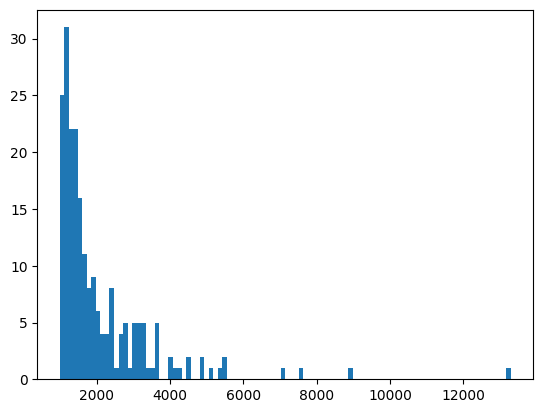

In [6]:
plt.hist(
    df["like_count_24h"][df["like_count_24h"]>1000],
    bins=100,
)

(array([2.723e+04, 7.896e+03, 3.787e+03, 2.353e+03, 1.528e+03, 1.126e+03,
        7.850e+02, 6.780e+02, 5.080e+02, 4.000e+02, 3.190e+02, 2.930e+02,
        2.300e+02, 2.190e+02, 1.860e+02, 1.620e+02, 1.540e+02, 1.150e+02,
        1.200e+02, 1.070e+02, 9.500e+01, 8.200e+01, 6.800e+01, 9.100e+01,
        6.300e+01, 6.700e+01, 5.600e+01, 5.600e+01, 4.800e+01, 5.100e+01,
        5.100e+01, 2.500e+01, 3.300e+01, 3.800e+01, 3.400e+01, 2.200e+01,
        3.700e+01, 4.000e+01, 2.700e+01, 3.100e+01, 1.900e+01, 1.700e+01,
        3.000e+01, 2.500e+01, 2.600e+01, 2.200e+01, 1.400e+01, 1.000e+01,
        1.900e+01, 1.700e+01, 1.000e+01, 1.800e+01, 1.000e+01, 7.000e+00,
        1.700e+01, 9.000e+00, 1.300e+01, 1.500e+01, 1.100e+01, 1.700e+01,
        7.000e+00, 1.000e+01, 1.100e+01, 1.000e+01, 1.000e+01, 3.000e+00,
        6.000e+00, 7.000e+00, 7.000e+00, 5.000e+00, 1.200e+01, 1.100e+01,
        6.000e+00, 6.000e+00, 6.000e+00, 7.000e+00, 7.000e+00, 8.000e+00,
        8.000e+00, 0.000e+00, 8.000e+0

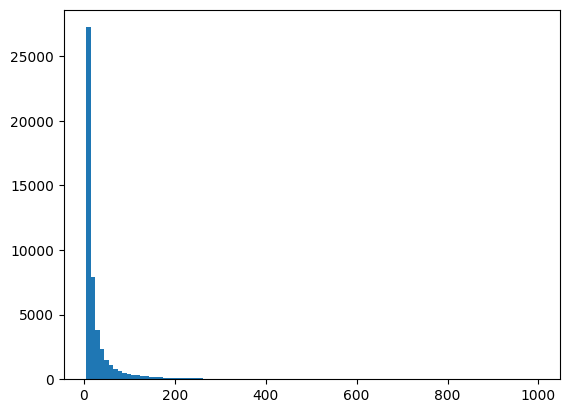

In [7]:
plt.hist(
    df["like_count_24h"][df["like_count_24h"] < 1000],
    # color="blue", edgecolor = "black",
    bins=100,
)

(array([5750.,    0., 4407.,    0., 3499.,    0., 2943.,    0.,    0.,
        2459.,    0., 2050.,    0., 1787.,    0., 1646.,    0.,    0.,
        1448.,    0., 1241.,    0., 1101.,    0.,    0., 1112.,    0.,
         912.,    0.,  848.,    0.,  759.,    0.,    0.,  734.,    0.,
         680.,    0.,  606.,    0.,  587.,    0.,    0.,  557.,    0.,
         467.,    0.,  481.,    0.,    0.,  411.,    0.,  367.,    0.,
         376.,    0.,  382.,    0.,    0.,  355.,    0.,  331.,    0.,
         312.,    0.,  305.,    0.,    0.,  296.,    0.,  243.,    0.,
         284.,    0.,    0.,  261.,    0.,  242.,    0.,  220.,    0.,
         228.,    0.,    0.,  192.,    0.,  205.,    0.,  182.,    0.,
         152.,    0.,    0.,  155.,    0.,  198.,    0.,  176.,    0.,
         133.]),
 array([ 5.  ,  5.44,  5.88,  6.32,  6.76,  7.2 ,  7.64,  8.08,  8.52,
         8.96,  9.4 ,  9.84, 10.28, 10.72, 11.16, 11.6 , 12.04, 12.48,
        12.92, 13.36, 13.8 , 14.24, 14.68, 15.12, 15.56, 16.

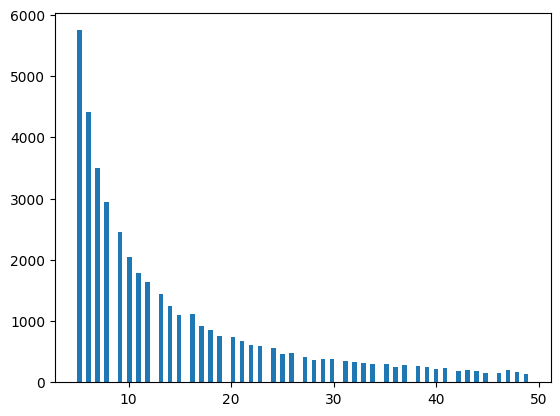

In [8]:
plt.hist(
    df["like_count_24h"][df["like_count_24h"] < 50],
    bins=100,
)

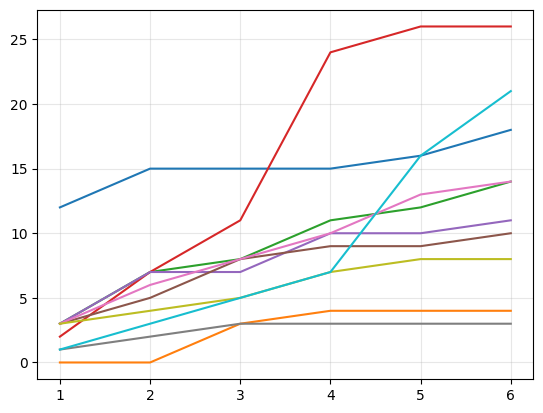

In [9]:
for i in range(10):
    plt.plot(
        [1, 2, 3, 4, 5, 6],
        df.loc[i, ["like_count_1h", "like_count_2h", "like_count_3h", "like_count_4h", "like_count_5h", "like_count_6h"]].to_numpy()
    )

plt.grid(alpha=0.3)

In [10]:
df = add_new_features(
    df=df,
    encoder=encoder,
    is_train=True,
)

X = df[features].to_numpy()
y = (df[["like_count_24h"]].to_numpy() - df[["like_count_6h"]].to_numpy())

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train the Model

### XGBoost

In [12]:
# params_grid = {
#     "n_estimators": [10, 15],
#     "max_depth": [10, 15, 20],
#     "max_leaves": [80, 100, 120, 140],
#     "max_bin": [35, 40, 45, 50],
# }
params_grid = {
    "n_estimators": [15],
    "max_depth": [10],
    "max_leaves": [100],
    "max_bin": [40],
}

model_list = []
best_score = np.Inf
best_params = None

for i, params in enumerate(get_params_grids(params_grid), start=1):
    score_list = []
    for train_index, valid_index in KFold(n_splits=5).split(X, y):
        # step 1
        model1 = xg.XGBRegressor(
            **params,
            objective="reg:squaredlogerror",
            random_state=250,
            eval_metric=mean_absolute_percentage_error,
        )
        model1.fit(X[train_index], y[train_index].ravel())

        # predict the pseudo label
        pseudo_label = model1.predict(X[valid_index])
        score = mean_absolute_percentage_error(
            y[valid_index] + X[valid_index][:, 5].reshape(-1, 1),
            pseudo_label + X[valid_index][:, 5],
        )
        print(f"Params {i}: {params}, step: 1, mean score: {score}")

        # step 2
        model2 = xg.XGBRegressor(
            **params,
            objective="reg:squaredlogerror",
            random_state=250,
            eval_metric=mean_absolute_percentage_error,
        )

        # concate the data with validation
        model2.fit(
            np.vstack([X[train_index], X[valid_index]]),
            np.hstack([y[train_index].ravel(), pseudo_label]),            
        )

        # predict the validation data
        y_pred = model2.predict(X[valid_index])
        score = mean_absolute_percentage_error(
            y[valid_index] + X[valid_index][:, 5].reshape(-1, 1),
            y_pred + X[valid_index][:, 5],
        )
        print(f"Params {i}: {params}, step: 2, mean score: {score}")

        model_list.append(model1)
        model_list.append(model2)

        score_list.append(score)
    mean_score = np.mean(score_list)
    # print(f"Params {i}: {params}, mean score: {mean_score}")

    if mean_score < best_score:
        best_score = mean_score
        best_params = params

print(f"Best params: {best_params}, mean score: {best_score}")

Params 1: {'n_estimators': 15, 'max_depth': 10, 'max_leaves': 100, 'max_bin': 40}, step: 1, mean score: 0.31509270965489866
Params 1: {'n_estimators': 15, 'max_depth': 10, 'max_leaves': 100, 'max_bin': 40}, step: 2, mean score: 0.31380504606200554
Params 1: {'n_estimators': 15, 'max_depth': 10, 'max_leaves': 100, 'max_bin': 40}, step: 1, mean score: 0.31375614787831935
Params 1: {'n_estimators': 15, 'max_depth': 10, 'max_leaves': 100, 'max_bin': 40}, step: 2, mean score: 0.31321393679897325
Params 1: {'n_estimators': 15, 'max_depth': 10, 'max_leaves': 100, 'max_bin': 40}, step: 1, mean score: 0.319924363480462
Params 1: {'n_estimators': 15, 'max_depth': 10, 'max_leaves': 100, 'max_bin': 40}, step: 2, mean score: 0.3191252913599887
Params 1: {'n_estimators': 15, 'max_depth': 10, 'max_leaves': 100, 'max_bin': 40}, step: 1, mean score: 0.3170045537838725
Params 1: {'n_estimators': 15, 'max_depth': 10, 'max_leaves': 100, 'max_bin': 40}, step: 2, mean score: 0.3166313627453247
Params 1: {'n

In [13]:
# model_list = []
# for train_index, valid_index in KFold(n_splits=5).split(X, y):
#     model = xg.XGBRegressor(
#         **best_params,
#         objective="reg:squaredlogerror",
#         eval_metric=mean_absolute_percentage_error,
#     )
#     model.fit(X[train_index], y[train_index].ravel())
#     model_list.append(model)

# model = xg.XGBRegressor(
#     **best_params,
#     objective="reg:squaredlogerror", 
#     eval_metric=mean_absolute_percentage_error,
# )
# model.fit(X, y)
# model_list.append(model)

### LightGBM

In [14]:
# params_grid = {
#     "n_estimators": [100, 150, 200, 250],
#     "max_depth": [50, 100],
#     "max_leaves": [100],
#     "max_bin": [10, 20, 30, 40],
# }

params_grid = {
    "n_estimators": [150],
    "num_leaves": [5],
    "max_depth": [50],
    "max_leaves": [100],
    "max_bin": [30],
}

best_score = np.Inf
best_params = None

for i, params in enumerate(get_params_grids(params_grid), start=1):
    score_list = []
    for train_index, valid_index in KFold(n_splits=5).split(X, y):
        model = LGBMRegressor(
            **params,
            force_row_wise=True,
            random_state=0,
            verbose=-1,
            objective=squared_log_error,
        )
        model.fit(X[train_index], y[train_index].ravel())
        y_pred = model.predict(X[valid_index])
        y_pred[y_pred < 0] = 0
        score = mean_absolute_percentage_error(
            y[valid_index] + X[valid_index][:, 5].reshape(-1, 1),
            (y_pred + X[valid_index][:, 5]),
        )
        score_list.append(score)
        model_list.append(model)
    mean_score = np.mean(score_list)
    print(f"Params {i}: {params}, mean score: {mean_score}")

    if mean_score < best_score:
        best_score = mean_score
        best_params = params

print(f"Best params: {best_params}, mean score: {best_score}")

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
Params 1: {'n_estimators': 150, 'num_leaves': 5, 'max_depth': 50, 'max_leaves': 100, 'max_bin': 30}, mean score: 0.3273411832338361
Best params: {'n_estimators': 150, 'num_leaves': 5, 'max_depth': 50, 'max_leaves': 100, 'max_bin': 30}, mean score: 0.3273411832338361


### CatBoost

In [15]:
import numpy as np
from catboost import CatBoostRegressor

class SquaredLogErrorObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        weights = weights if weights is not None else np.ones(len(targets))
        epsilon = 1e-5
        approxes[approxes < -1] = -1 + epsilon
        targets[targets < -1] = -1 + epsilon

        grad = (np.log1p(approxes) - np.log1p(targets)) / (approxes + 1)
        hess = (-np.log1p(approxes) + np.log1p(targets) + 1) / (approxes + 1) ** 2

        return list(zip(grad * weights, hess * weights))


params_grid = {
    "n_estimators": [120],
    "max_depth": [4],
    # "max_bin": [30],
    # "learning_rate": [1e-2],
}

best_score = np.Inf
best_params = None

for i, params in enumerate(get_params_grids(params_grid), start=1):
    score_list = []
    for train_index, valid_index in KFold(n_splits=5).split(X, y):
        model = CatBoostRegressor(
            **params,
            random_state=250,
            verbose=0,
            objective=SquaredLogErrorObjective(),
            eval_metric='MAPE',
        )
        model.fit(X[train_index], y[train_index].ravel())
        y_pred = model.predict(X[valid_index])
        score = mean_absolute_percentage_error(
            y[valid_index] + X[valid_index][:, 5].reshape(-1, 1),
            (y_pred + X[valid_index][:, 5]),
        )
        score_list.append(score)
        model_list.append(model)
    mean_score = np.mean(score_list)
    print(f"Params {i}: {params}, mean score: {mean_score}")

    if mean_score < best_score:
        best_score = mean_score
        best_params = params

print(f"Best params: {best_params}, mean score: {best_score}")

/Users/jiawei/love_pred/lib/python3.10/site-packages/catboost/core.py:2230: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/jiawei/love_pred/lib/python3.10/site-packages/catboost/core.py:2230: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/jiawei/love_pred/lib/python3.10/site-packages/catboost/core.py:2230: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/jiawei/love_pred/lib/python3.10/site-packages/catboost/core.py:2230: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/jiawei/love_pred/lib/python3.10/site-packages/catboost/core.py:2230: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Params 1: {'n_estimators': 120, 'max_depth': 4}, mean score: 0.3326504833059398
Best params: {'n_estimators': 120, 'max_depth': 4}, mean score: 0.3326504833059398


## Predit the Public Data

In [16]:
public_df = pd.read_csv(os.path.join("data", "intern_homework_public_test_dataset.csv"))
public_df = add_new_features(
    df=public_df,
    encoder=encoder,
    is_train=False,
)
X_public = public_df[features].to_numpy()
y_public = public_df[["like_count_24h"]].to_numpy() - public_df[["like_count_6h"]].to_numpy()

In [17]:
pred_list = []
for model in model_list:
    y_pred = model.predict(X_public)
    # print(
    #     mean_absolute_percentage_error(
    #         y_public + X_public[:, 5].reshape(-1, 1),
    #         y_pred.reshape(-1, 1) + X_public[:, 5].reshape(-1, 1)
    #     )
    # )
    y_pred[y_pred < 0] = 0
    pred_list.append(y_pred)

public_pred = np.array(pred_list).mean(axis=0) + X_public[:, 5]
score = mean_absolute_percentage_error(y_public + X_public[:, 5].reshape(-1, 1), public_pred)
print(f"Public MAPE: {score}")

Public MAPE: 0.32637580317091414


In [18]:
for i, model in enumerate(model_list):
    print(i, model)

0 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_percentage_error at 0x1643f1900>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=40, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=100, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=15,
             n_jobs=None, num_parallel_tree=None,
             objective='reg:squaredlogerror', ...)
1 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=N

## Result Analysis

In [19]:
feature_importances_df = pd.DataFrame({"Feature name": features, "Feature importances": model_list[13].feature_importances_})
feature_importances_df.sort_values(by="Feature importances", ascending=False, ignore_index=True)

,Feature name,Feature importances
0,time,135
1,like_count_1h,87
2,weekday_te,87
3,comment_count_6h-3h/3,87
4,like_count_6h-4h/2,65
5,like_count_6h-2h/4,44
6,forum_stats,23
7,forum_id_te,17
8,like_count_6h-3h/3,16
9,like_count_6h-1h/5,15


In [20]:
public_df["like_count_24h_pred"] = public_pred
public_df[[
    "like_count_1h",
    "like_count_2h",
    "like_count_3h",
    "like_count_4h",
    "like_count_5h",
    "like_count_6h",
    "like_count_24h",
    "like_count_24h_pred"
]]

,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,like_count_24h,like_count_24h_pred
0,2,7,7,12,13,14,16,20.525026
1,1,1,1,1,3,4,8,10.894509
2,2,2,3,3,3,4,8,7.254741
3,0,0,1,2,3,3,6,6.680744
4,12,21,39,54,77,107,211,148.298364
...,...,...,...,...,...,...,...,...
9995,5,8,8,8,8,8,20,13.364034
9996,3,6,12,13,14,15,18,21.456414
9997,2,2,2,3,3,3,6,7.408673
9998,0,0,1,1,2,2,5,7.088069


(array([  1.,   1.,   2.,   4.,   0.,   3.,   2.,   2.,   1.,   3.,   4.,
          2.,   5.,   6.,   1.,   6.,   6.,   9.,   5.,  10.,  16.,  10.,
         13.,  14.,  18.,  13.,  26.,  26.,  36.,  33.,  34.,  34.,  42.,
         47.,  56.,  60.,  73.,  74.,  87.,  88., 102., 104., 133., 114.,
        162., 150., 171., 188., 174., 194., 168., 201., 208., 191., 204.,
        190., 245., 211., 233., 221., 222., 256., 243., 232., 249., 248.,
        226., 212., 201., 184., 216., 207., 164., 195., 190., 183., 152.,
        176., 150., 145., 131., 117., 129.,  85., 101.,  89., 104.,  79.,
         87.,  78.,  84.,  74.,  67.,  43.,  51.,  50.,  52.,  40.,  28.,
         23.]),
 array([-1.34713674, -1.32370889, -1.30028104, -1.2768532 , -1.25342535,
        -1.22999751, -1.20656966, -1.18314181, -1.15971397, -1.13628612,
        -1.11285827, -1.08943043, -1.06600258, -1.04257473, -1.01914689,
        -0.99571904, -0.9722912 , -0.94886335, -0.9254355 , -0.90200766,
        -0.87857981, -0.85

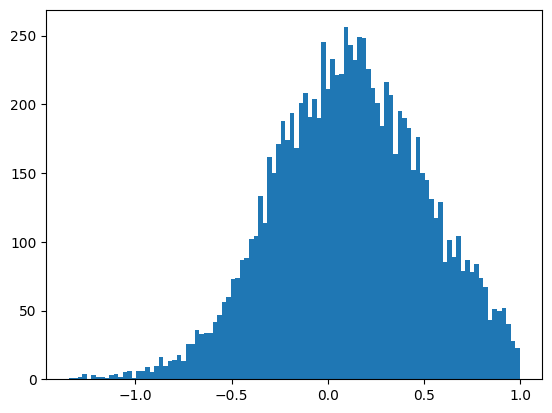

In [21]:
diff = public_df["like_count_24h"] - public_df["like_count_24h_pred"]
plt.hist(
    (diff / public_df["like_count_24h"]),
    bins=100,
)

In [22]:
diff[diff > 500]

137       527.52608
352      877.579168
420     2331.275453
670       582.19657
744     1119.828812
           ...     
9682     712.871269
9715     649.629218
9727     801.211791
9829    1466.201463
9850    1888.744066
Length: 84, dtype: object

In [2]:
df1 = pd.DataFrame({"feature1": [1, 2, 3]})
df1

,feature1
0,1
1,2
2,3


In [5]:
def add_feature(df):
    df["feature2"] = df["feature1"] + 1
    return df

In [7]:
add_feature(df1)

,feature1,feature2
0,1,2
1,2,3
2,3,4


In [8]:
df1

,feature1,feature2
0,1,2
1,2,3
2,3,4


In [13]:
hours = [1, 2, 3, 4, 5, 6]
sum([df[f"like_count_{i}h"] for i in hours])

0        91
1        15
2        55
3        96
4        48
         ..
49995     7
49996     0
49997     7
49998    41
49999    18
Length: 50000, dtype: int64

In [15]:
"title" in df.columns

True